# Aldy: Figures and Tables

Here you can find the scripts that somehow parse output from Aldy, Astrolabe and Cypiripi ([full output is located here](data)), and generate the tables used in our paper. Human supervision is needed. The code is of "write-once-and-pray-never-again" quality, and is provided mostly for the sake of completeness. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Aldy:-Figures-and-Tables" data-toc-modified-id="Aldy:-Figures-and-Tables-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Aldy: Figures and Tables</a></span><ul class="toc-item"><li><span><a href="#Load-sample-data-and-ground-truth-set-from-samples.xlsx" data-toc-modified-id="Load-sample-data-and-ground-truth-set-from-samples.xlsx-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load sample data and ground truth set from <code>samples.xlsx</code></a></span></li><li><span><a href="#Load-and-parse-various-log-files-and-tool-outputs" data-toc-modified-id="Load-and-parse-various-log-files-and-tool-outputs-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load and parse various log files and tool outputs</a></span></li><li><span><a href="#Check-the-number-of-correct-calls" data-toc-modified-id="Check-the-number-of-correct-calls-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Check the number of correct calls</a></span></li><li><span><a href="#Generate-the-tables" data-toc-modified-id="Generate-the-tables-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Generate the tables</a></span></li><li><span><a href="#How-many-alleles-cannot-be-tagged?" data-toc-modified-id="How-many-alleles-cannot-be-tagged?-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>How many alleles cannot be tagged?</a></span></li><li><span><a href="#Figures" data-toc-modified-id="Figures-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Figures</a></span><ul class="toc-item"><li><span><a href="#Main-plotting-function" data-toc-modified-id="Main-plotting-function-1.6.1"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Main plotting function</a></span></li><li><span><a href="#How-copy-number-rescaling-works-(PGRNseq)" data-toc-modified-id="How-copy-number-rescaling-works-(PGRNseq)-1.6.2"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>How copy number rescaling works (PGRNseq)</a></span></li><li><span><a href="#CYP2D6.5-Deletion" data-toc-modified-id="CYP2D6.5-Deletion-1.6.3"><span class="toc-item-num">1.6.3&nbsp;&nbsp;</span><em>CYP2D6.5</em> Deletion</a></span></li><li><span><a href="#CYP2D6.68-Fusion" data-toc-modified-id="CYP2D6.68-Fusion-1.6.4"><span class="toc-item-num">1.6.4&nbsp;&nbsp;</span><em>CYP2D6.68</em> Fusion</a></span></li></ul></li></ul></li></ul></div>

In [27]:
import pandas as pd
import numpy as np
import os, re, sys, scipy, glob
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
def maybeint(s):
    try: return (int(s), s)
    except ValueError: return (0, s)

## Load sample data and ground truth set from `samples.xlsx`

[Input file is provided here](data/samples.xlsx).

In [10]:
# Load PGRNseq v1 data
df = pd.read_excel('data/samples.xlsx', header=[0,2], sheetname='PGRNseq-v1 (CDC)', parse_dates=False)
genes = set([x[0] for x in df.columns.values[4:]]) - set('SLCO1B1 CYP2B6'.split())
genes = sorted(map(str, genes))
for g in genes:
    df[g,'Validated'] = df[g].Validated.apply(lambda x: sorted(re.split(r'[+/]', x), key=maybeint))
    df[g,'Additional'] = df[g].Additional.apply(lambda x: [] if pd.isnull(x) else sorted(re.split(r'[+/]', x), key=maybeint))
    df[g,'Truth'] = np.where(df[g].Additional.str.len() == 0, df[g].Validated, df[g].Additional)
data_v1 = df

# Load PGRNseq v2 data
df = pd.read_excel('data/samples.xlsx', header=[0,1], sheetname='PGRNseq-v2', parse_dates=False)
for g in ['CYP2D6']:
    df[g,'Validated'] = df[g].Validated.apply(lambda x: sorted(re.split(r'[+/]', x), key=maybeint))
    df[g,'Additional'] = df[g].Additional.apply(lambda x: [] if pd.isnull(x) else sorted(re.split(r'[+/]', x), key=maybeint))
    df[g,'Truth'] = np.where(df[g].Additional.str.len() == 0, df[g].Validated, df[g].Additional)
df.head()
for g in set(x[0] for x in df.columns.values[5:] if x[0] != 'CYP2D6'):
    del df[g]
data = pd.merge(df.reset_index(), data_v1.reset_index(), 
                on=[('index', '')], how='outer', suffixes=('', '_y'))
for i in 'Validated Truth Additional Comments'.split():
    data['CYP2D6', i] = np.where(pd.isnull(data['CYP2D6', i]), 
                                 data['CYP2D6_y', i], data['CYP2D6', i])
data = data.select(lambda x: not re.search('_y', x[0]) and x[0] not in 'SLCO1B1 CYP2B6'.split(), axis=1)

# Load Illumina data
df = pd.read_excel('data/samples.xlsx', header=[0,1], sheetname='Illumina', parse_dates=False)
for g in ['CYP2D6']:
    df[g,'Validated'] = df[g].Validated.apply(lambda x: sorted(re.split(r'[+/]', x), key=maybeint))
    df[g,'Additional'] = df[g].Additional.apply(lambda x: [] if pd.isnull(x) else sorted(re.split(r'[+/]', x), key=maybeint))
    df[g,'Truth'] = np.where(df[g].Additional.str.len() == 0, df[g].Validated, df[g].Additional)
df.head()
for g in set(x[0] for x in df.columns.values[5:] if x[0] != 'CYP2D6'):
    del df[g]
data = pd.merge(data.reset_index(), df.reset_index(),
                on=[('index', '')], how='outer', suffixes=('', '_y'))
for i in 'Validated Truth Additional Comments'.split():
    data['CYP2D6', i] = np.where(pd.isnull(data['CYP2D6', i]), 
                                 data['CYP2D6_y', i], data['CYP2D6', i])
for i in 'ID Ethnicity Relationship'.split():
    data['Family', i] = np.where(pd.isnull(data['Family', i]), 
                                 data['Family_y', i], data['Family', i])
data = data.select(lambda x: not re.search('_y', x[0]) and x[1] not in ['Additional'] and x[0] != 'level_0', axis=1)
data.sample(3)

Sample    index Family                           CYP2D6                   \
                    ID Ethnicity Relationship Validated Comments   Truth   
23      NA12331   1328  European            C    [4, 9]      NaN  [4, 9]   
167     NA18942    NaN       NaN          NaN    [2, 2]      NaN  [2, 2]   
206     NA23872    NaN       NaN          NaN    [2, 2]      NaN  [2, 2]   

Sample     PGXT    CYP2A6                            CYP2C19           \
             ID Validated                 Comments Validated Comments   
23          NaN       NaN                      NaN       NaN      NaN   
167     PGxT171    [1, 1]  Only one copy of CYP2A6    [1, 1]      NaN   
206     PGxT232    [1, 1]                      NaN    [1, 8]      NaN   

Sample    CYP2C8             CYP2C9             CYP3A4             CYP3A5  \
       Validated Comments Validated Comments Validated Comments Validated   
23           NaN      NaN       NaN      NaN       NaN      NaN       NaN   
167       [1, 1]      NaN    [1, 1]      NaN    [1, 1]      NaN    [3, 3]   
206       [1, 3]      NaN    [1, 2]      NaN    [1, 1]      NaN    [3, 3]   

Sample             CYP4F2                       TPMT               DPYD  \
       Comments Validated         Comments Validated Comments Validated   
23          NaN       NaN              NaN       NaN      NaN       NaN   
167         NaN    [1, 1]              NaN    [1, 1]      NaN    [1, 1]   
206         NaN    [1, 3]  Either *2 or *4    [1, 1]      NaN    [9, 9]   

Sample           CYP2A6 CYP2C19  CYP2C8  CYP2C9  CYP3A4  CYP3A5  CYP4F2  \
       Comments   Truth   Truth   Truth   Truth   Truth   Truth   Truth   
23          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
167         NaN  [1, 4]  [1, 1]  [1, 1]  [1, 1]  [1, 1]  [3, 3]  [1, 1]   
206         NaN  [1, 1]  [1, 8]  [1, 3]  [1, 2]  [1, 1]  [3, 3]  [2, 3]   

Sample    DPYD    TPMT  
         Truth   Truth  
23         NaN     NaN  
167     [1, 1]  [1, 1]  
206     [9, 9]  [1, 1]

## Load and parse various log files and tool outputs

In [28]:
def load_results(path, gene):
    df = defaultdict(dict)
    # Get Cypiripi log
    def parse_cypiripi(fp):
        call = [l.strip() for l in open(fp).readlines()]
        if 'Solutions:' not in call: 
            print('ERROR', fp)
            return
        call = map(lambda x: x.split('[')[1][:-2].strip().split(), 
                   filter(lambda y: 'CPLEX' in y, call[call.index('Solutions:') + 1:]))
        def parse(c):
            d = []
            for a in c:
                i = a.split('×')
                if len(i) == 2: 
                    if i[1] != '2D7': d += int(i[0]) * [i[1]]
                else: d += [i[0]]
            return map(lambda x: re.findall(r'^\d+', x[1:])[0] if x != '2D7' else x, d)
        call = list(map(lambda x: sorted(x, key=maybeint), map(parse, call)))
        return call[0] if len(call) == 1 else call
    # Astrolabe only supports these genes
    if gene in ['CYP2D6', 'CYP2C9', 'CYP2C19']:
        for fp in glob.glob(path + '/astrolabe/*.log'):
            call = next(l for l in open(fp).readlines() if l.startswith(gene))
            call = call.split()[1].replace(gene, '')
            call = list(map(lambda x: x[1:], call.split('/')))
            call = sorted(call, key=maybeint)
            df['astrolabe'][os.path.basename(fp)[:7]] = call
    # Cypiripi only works with CYP2D6
    if gene in ['CYP2D6']:
        for fp in glob.glob(path + '/cypiripi/*.results'):
            df['cypiripi'][os.path.basename(fp)[:7]] = parse_cypiripi(fp)
    for fp in glob.glob(path + '/aldy/*-{}.log'.format(gene)):
        call = next(l for l in open(fp).readlines() if l.startswith('Result is'))
        call = map(lambda x: [re.findall(r'^\d+', y)[0] for y in x], eval(call[11:]))
        call= list(map(lambda x: sorted(x, key=maybeint), call))
        df['aldy'][os.path.basename(fp)[:7]] = call[0] if len(call) == 1 else call
    return pd.DataFrame.from_dict(df)

def get_truth(gene, dx):    
    dy = pd.merge(dx, data, on='index')
    def strip2(x):
        if not isinstance(x, list): return x
        return sorted([re.findall(r'^\d+', y.strip())[0] if y[0].isdigit() else y for y in x], key=maybeint)
    dx['truth'] = list(map(strip2, dy[(gene, 'Truth')]))
    dx['validation'] = list(map(strip2, dy[(gene, 'Validated')]))
    dx['family'] = dy[('Family', 'ID')] 
    dx['rel'] = dy[('Family', 'Relationship')]
    
    def filter_del(x):
        return [y for y in x if y != '5'] if isinstance(x, list) else x
    def filter_cypiripi(x):
        if isinstance(x, list):
            return list(map(filter_cypiripi, filter(lambda y: y != '2D7', x)))
        return x
    def criteria(k, F):
        def f(x):
            xa = F(x[k])
            ya = filter_del(x.truth)
            return xa == ya or (isinstance(xa, list) and ya in xa)
        return f
    dx['truth_ok'] = True
    dx['aldy_ok'] = dx.apply(criteria('aldy', filter_del), axis=1)
    dx['validation_ok'] = dx.apply(criteria('validation', filter_del), axis=1)
    
    if 'astrolabe' in dx:
        dx['astrolabe_ok'] = dx.apply(criteria('astrolabe', filter_del), axis=1)
    if 'cypiripi' in dx:
        dx['cypiripi_ok'] = dx.apply(criteria('cypiripi', filter_cypiripi), axis=1)

    def get_group(x):
        if not isinstance(x.truth, list):
            return 'unknown'
        elif (gene == 'CYP2D6' and len(set('68 36 76 78 13'.split()) & set(x.truth)) > 0) or \
            (gene == 'CYP2A6' and '12' in x.truth):
            return 'fusion'
        elif (gene == 'CYP2D6' and '5' in x.truth) or (gene == 'CYP2A6' and '4' in x.truth):
            return 'deletion'
        elif len(x.truth) > 2:
            return 'multiplication'
        else:
            return 'normal'
    dx['group'] = dx.apply(get_group, axis=1)
    dx['comments'] = dy[(gene, 'Comments')].fillna('')
    return dx

def get_df(sample_group, gene):
    dx = load_results('data/' + sample_group, gene).reset_index()
    return get_truth(gene, dx)

d_set = {}
for s in 'pgrnseq-baylor pgrnseq-cdc illumina-1000genomes'.split():
    d_set[s] = get_df(s, 'CYP2D6')
d_set['pgrnseq-baylor'].sample(3)

ERROR data/illumina-1000genomes/cypiripi/NA12877.fq.sam.results


,index,aldy,astrolabe,cypiripi,truth,validation,family,rel,truth_ok,aldy_ok,validation_ok,astrolabe_ok,cypiripi_ok,group,comments
2,HG00423,"[10, 10, 10]","[10, 10]","[10, 10, 10]","[10, 10, 10]","[10, 10, 10]",SH007,C,True,True,True,False,True,multiplication,CNV data not clear cut; could be a *36+*10
30,NA10854,"[1, 4]","[1, 4]","[2D7, 1, 4]","[1, 4]","[1, 4]",1349,M,True,True,True,True,True,normal,
62,NA18508,"[2, 5]","[2, 2]",[2],"[2, 5]","[2, 5]",Y009,M,True,True,True,False,True,deletion,


## Check the number of correct calls

Some Cypiripi numbers need manual checking.

In [29]:
gene = 'CYP2D6' # change this for other genes (and remove 'cypiripi_ok' from the last line)
for sset in 'pgrnseq-baylor illumina-1000genomes'.split():
    print(sset, '/', gene)
    d_cdc = get_df(sset, gene)
    g = d_cdc.groupby('group')
    # Uncomment to show details
    # for ng, gg in g:
    #    display(gg[gg.aldy != gg.astrolabe]) 
    #    pass
    y=g.sum()
    s=y.sum()
    s.name='total'
    y=y.append(s)
    display(y[['validation_ok', 'aldy_ok', 'astrolabe_ok', 'cypiripi_ok', 'truth_ok']])

pgrnseq-baylor / CYP2D6


,validation_ok,aldy_ok,astrolabe_ok,cypiripi_ok,truth_ok
group,,,,,
deletion,8.0,9.0,0.0,7.0,9.0
fusion,12.0,12.0,0.0,0.0,12.0
multiplication,5.0,6.0,0.0,4.0,6.0
normal,62.0,69.0,68.0,50.0,69.0
total,87.0,96.0,68.0,61.0,96.0


illumina-1000genomes / CYP2D6
ERROR data/illumina-1000genomes/cypiripi/NA12877.fq.sam.results


,validation_ok,aldy_ok,astrolabe_ok,cypiripi_ok,truth_ok
group,,,,,
fusion,4.0,14.0,0.0,0.0,14.0
multiplication,0.0,2.0,0.0,0.0,2.0
normal,7.0,9.0,3.0,3.0,9.0
total,11.0,25.0,3.0,3.0,25.0


## Generate the tables

This is a rough code which generates tables. Manual checks are needed later on.

In [45]:
from collections import Counter

# This function prints nice diplotype
def parse(xx):
    if not isinstance(xx, list) or xx == []: 
        return ''
    if isinstance(xx[0], list):
        return ' or '.join(set(map(parse, xx)))
    
    x = list(filter(lambda y: y != '2D7', xx))
    if len(x) == 1:
        res = '*5/*{}'.format(*x)
    elif len(x) == 2:
        res = '*{}/*{}'.format(*x)
    else:
        x = defaultdict(int, Counter(x))
        a = [[], []]
        ali = 0
        while x['36'] > 0 and x['10'] > 0:
            a[ali % 2] += ['36', '10']
            ali += 1
            x['36'] -= 1
            x['10'] -= 1
        while x['4'] > 0 and x['68'] > 0:
            a[ali % 2] += ['68', '4']
            ali += 1
            x['4'] -= 1
            x['68'] -= 1
        while x['2'] > 0 and x['78'] > 0:
            a[ali % 2] += ['78', '2']
            ali += 1
            x['2'] -= 1
            x['78'] -= 1
        for h, c in x.items():
            if c > 0:
                a[ali % 2] += c * [h]
                ali += 1
        if len(a[1]) == 0: 
            a[1] = [a[0][-1]]
            a[0] = a[0][::-2]
        if len(a[0]) > len(a[1]):
            a[0], a[1] = a[1], a[0]
        res = '/'.join(map(lambda x: '+'.join(map(lambda y: '*' + y, x)), a))
    return res
        
for sset in 'pgrnseq-baylor illumina-1000genomes'.split():
    print(sset)
    d_cdc = get_df(sset, 'CYP2D6')
    for y in 'aldy astrolabe cypiripi validation'.split():
        d_cdc[y] = d_cdc[y].apply(parse)
    def check(r, k):
        return '\{}{{{}}}'.format('OK' if r[k + '_ok'] else 'NO', r[k])
    def case(r):
        r = re.split(r'[+/]', r.aldy)
        if set(['*36', '*68', '*78']) & set(r):
            return 'Fusion'
        elif '*5' in r:
            return 'Deletion (*5)'
        elif len(r) > 2:
            return 'Multiplication'
        return ''
    i = 0
# Uncomment for table print (needs work obviously based on your needs)
#     for ri, r in d_cdc.iterrows():
#         print('{} & {:10} & {:20} & {:12} & {:25} & {:20} & {} \\\\'.format(
#             r['index'], r.family + '/' + r.rel,
#             check(r, 'aldy'), check(r, 'astrolabe'), check(r, 'cypiripi'), r.validation,
#             case(r)
#         ))
#         i += 1
    #display(d_cdc[['index', 'family', 'aldy', 'astrolabe', 'cypiripi', 'validation']])

pgrnseq-baylor
illumina-1000genomes
ERROR data/illumina-1000genomes/cypiripi/NA12877.fq.sam.results


## How many alleles cannot be tagged?

Notes:
- "structural variations" refer to all alleles which change normal copy number structure (e.g. \*13, \*68 etc.)
- "ambiguous" calls (obtained initially from Aldy's calls) are 2-copy samples that can be explained by multiple major star-allele combinations

## Figures

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import re, os, collections
from matplotlib import rc

First load the original data:

In [7]:
profiles = collections.defaultdict(list)
for sample in 'NA11892 NA12878 NA12155'.split():
    with open('data/plots/{}.bam.profile'.format(sample)) as f:
        pos = 0
        for l in f:
            l = l.strip().split()
            profiles[sample].append(float(l[0]))
            pos += 1
def load_profile(profile_path):
    result = []
    with open(profile_path) as f: # now it is NA19686
        for l in f:
            l = l.strip().split()
            if l[0] != 'chr22': continue
            l = list(map(int, l[1:]))
            l[0] -= 42518969
            if l[0] < 0: continue
            result += [0] * (l[0] - len(result))
            result.append(l[1])
    return result
pgrnref = load_profile('data/plots/pgrnseq.profile')
len(pgrnref)
xprofiles = {}
for pn, profile in profiles.items():
    r = (28495, 29281)
    rc = 2 * float(sum(profile[slice(*r)])) / sum(pgrnref[slice(*r)])
    scale = 2.0 / rc
    xprofiles[pn] = [i for i in profile]
    print('Loaded', pn, 'with scaling factor', scale)
    profiles[pn] = [scale * i for i in profile]
CYP_REGIONS = { # intervals are inclusive on both sides
    '6.9e': ( 3605,  3783), '6.9i': ( 3300,  3605),  '6.0i': ( 7822,  8000),
    '6.8i': ( 3784,  3881),  '6.8e': ( 3882,  4023),
    '6.7i': ( 4024,  4477),  '6.7e': ( 4478,  4665),
    '6.6i': ( 4666,  4872),  '6.6e': ( 4873,  5014),
    '6.5i': ( 5015,  5204),  '6.5e': ( 5205,  5381),
    '6.4i': ( 5382,  5814),  '6.4e': ( 5815,  5975),
    '6.3i': ( 5976,  6063),  '6.3e': ( 6064,  6216),
    '6.2i': ( 6217,  6768),  '6.2e': ( 6769,  6940),
    '6.1i': ( 6941,  7642),  '6.1e': ( 7643,  7822),

     '7.9i': (17000, 17316),  '7.9e': (17317, 17495),
    '7.8i': (17496, 17593),  '7.8e': (17594, 17735),
    '7.7i': (17736, 18189),  '7.7e': (18190, 18377),
    '7.6i': (18378, 18571),  '7.6e': (18572, 18713),
    '7.5i': (18714, 18905),  '7.5e': (18906, 19082),
    '7.4i': (19083, 19507),  '7.4e': (19508, 19668),
    '7.3i': (19669, 19756),  '7.3e': (19757, 19909),
    '7.2i': (19910, 20438),  '7.2e': (20439, 20610),
    '7.1i': (20611, 21312),  '7.1e': (21313, 21493),  '7.0i': (21493, 22000)
}

Loaded NA11892 with scaling factor 0.6777117303682453
Loaded NA12878 with scaling factor 0.7737449026072621
Loaded NA12155 with scaling factor 0.8061012056088495


### Main plotting function

This code is both ancient and awful, and was a quick hack to get Matplotlib working the way I want. Provided only for the sake of completeness.

In [20]:
import matplotlib
# Use this for publication
# matplotlib.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
matplotlib.rcParams['figure.autolayout'] = False

def xplot(title, mima=None, **kwargs):
    matplotlib.rcParams['text.usetex'] = True # True for nice figure
    matplotlib.rcParams['font.size'] = 12

    if len(kwargs) > 1:
        matplotlib.rcParams['figure.figsize'] = (18, 5)
        x = list(kwargs.values())[1][0][:]
        y = [0] * len(x)
        for rn, r in CYP_REGIONS.items():
            w = sum(x[r[0]:r[1]]) / float(sum(pgrnref[r[0]:r[1]]))
            for i in range(r[0], r[1]+1):
                y[i] = w
        f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
    else:
        matplotlib.rcParams['figure.figsize'] = (18, 2)
        f, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax4, ax5, y = None, None, None

    for axi, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):
        if ax is None: continue
        for (a, b) in [(5483,5995),(3885,4667),(19335,19759),(17598,18380)]:
            ax.axvspan(a, b, color='orange', alpha=0.5, lw=0)
        if mima is not None:
            mi, ma = mima
            ax.fill_between(range(len(mi)), mi, ma, facecolor='red', lw=0)

        if axi < 3:
            ax.plot(pgrnref, '--', color='black')
            if len(kwargs) > 1:
                ax.plot(list(kwargs.values())[1][0], label='', **list(kwargs.values())[1][1])
            ax.set_ylim(0, 3000)
        elif len(kwargs) > 1:
            ax.plot([1] * len(pgrnref), color='black')
            ax.plot([.5] * len(pgrnref), **list(kwargs.values())[0][1])
            ax.plot([1.5] * len(pgrnref), **list(kwargs.values())[0][1])
            ax.plot([2.5] * len(pgrnref), **list(kwargs.values())[0][1])
            ax.plot(y, label='', **list(kwargs.values())[1][1])
            ax.set_ylim(0, 2.5)
            ax.set_yticklabels(['0', '1', '2', '3', '4', '5'])

        ax.xaxis.tick_top()

        cr = sorted([(a[1], v) for v, a in CYP_REGIONS.items() if not v[2:] in ['9i', '0i', '6i', '8i', '7i', '5i', '3i']])
        ax.set_xticks([x for x, _ in cr])
        ax.set_xticklabels([('exon ' if x[-1] == 'e' else 'intron ') + x[-2] for _, x in cr])
        for tick in ax.get_xticklabels():
            tick.set_fontsize(8)
            tick.set_rotation(45)

    ax1.set_xlim(3300, 8000)
    if ax4 is not None:
        ax4.set_xlim(3300, 8000)
        ax5.set_xlim(17000, 22000)
        ax6.axis('off')
    ax2.set_xlim(17000, 22000)
    ax3.set_xlim(26900, 32000)

    # hide the spines between ax and ax2
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax3.spines['left'].set_visible(False)

    if ax4 is not None:
        ax4.spines['right'].set_visible(False)
        ax5.spines['left'].set_visible(False)
        ax5.tick_params(labeltop='off')
        ax4.tick_params(labeltop='off')
        ax5.yaxis.tick_right()

    ax1.yaxis.tick_left()
    ax1.tick_params(labelright='off')
    ax2.tick_params(labelleft='off')
    ax3.yaxis.tick_right()

    ax1.set_xlabel('CYP2D6')
    ax2.set_xlabel('CYP2D7')
    ax3.set_xlabel('CYP2D8')

    f.subplots_adjust(hspace=.7)

    d = .02
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((1-d,1+d), (-d,+d), **kwargs)
    ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d,+d), (1-d,1+d), **kwargs)
    ax2.plot((-d,+d), (-d,+d), **kwargs)

    kwargs.update(transform=ax3.transAxes)  # switch to the bottom axes
    ax3.plot((-d,+d), (1-d,1+d), **kwargs)
    ax3.plot((-d,+d), (-d,+d), **kwargs)

    if ax4 is not None:
        kwargs = dict(transform=ax4.transAxes, color='k', clip_on=False)
        ax4.plot((1-d,1+d), (-d,+d), **kwargs)
        ax4.plot((1-d,1+d),(1-d,1+d), **kwargs)

        kwargs.update(transform=ax5.transAxes)  # switch to the bottom axes
        ax5.plot((-d,+d), (1-d,1+d), **kwargs)
        ax5.plot((-d,+d), (-d,+d), **kwargs)

        ax1.set_ylabel('Rescaled\nPGRN-Seq', rotation=90, size='12', x=1.1)
        ax4.set_ylabel('Normalized\nPGRN-Seq', rotation=90, size='12', x=1.2)

    st = None
    return (ax1, ax2, ax3, ax4, ax5, y,f)

### How copy number rescaling works (PGRNseq)

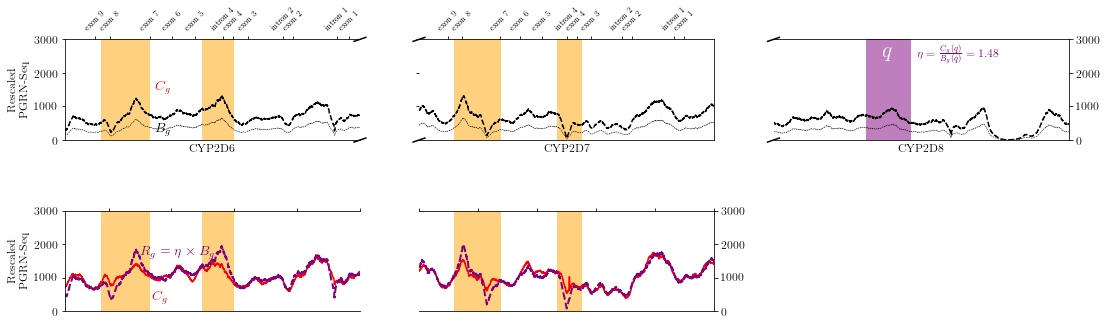

In [21]:
# Figure 1
single = ([float(x)/2 for x in pgrnref], dict(color='black', linestyle='--', lw=.5))
p = xprofiles['NA11892']
ax1, ax2, ax3, ax4, ax5, y, fig = xplot('', None, insertion=(p, dict(color='red')), single=single)

ax1.annotate('$B_g$', xy=(155,148+55), xycoords='figure points', size='14')
ax1.annotate('$C_g$', xy=(155,190+55), xycoords='figure points', color='red', size='14')

w=sum(p[i] for i in range(28495, 29281))/sum(pgrnref[i] for i in range(28495, 29281))
ax3.axvspan(28495, 29281, color='purple', alpha=0.5, lw=0)
ax3.annotate('$q$', xy=(870+12,225+55), xycoords='figure points', color='white', size='22')
ax3.annotate('$\\eta=\\frac{C_g(q)}{B_g(q)}=1.48$', xy=(905+12,220+55), xycoords='figure points', color='purple')

for ax in [ax4, ax5]:
    ax.cla()
    for (a, b) in [(5483,5995),(3885,4667),(19335,19759),(17598,18380)]:
        ax.axvspan(a, b, color='orange', alpha=0.5, lw=0)
    ax.plot(xprofiles['NA11892'], color='red')
    ax.plot([i*w for i in pgrnref], '--', color='purple', lw=2)
    ax.set_ylim(0, 3000)
ax4.set_xlim(3300, 8000)
ax5.set_xlim(17000, 22000)
ax4.set_ylabel('Rescaled\nPGRN-Seq', rotation=90, size='12', x=1.2)

ax4.annotate('$C_g$', xy=(140+12,35), xycoords='figure points', color='red', size='14')
ax5.annotate('$R_g = \\eta\\times B_g$', xy=(128+12,80), xycoords='figure points', color='purple', size='14')
# plt.savefig('fig_sup_1.pdf', dpi=fig.dpi, bbox_inches='tight')

### _CYP2D6.5_ Deletion

(26900.0, 32000.0, 0.0, 3000.0)

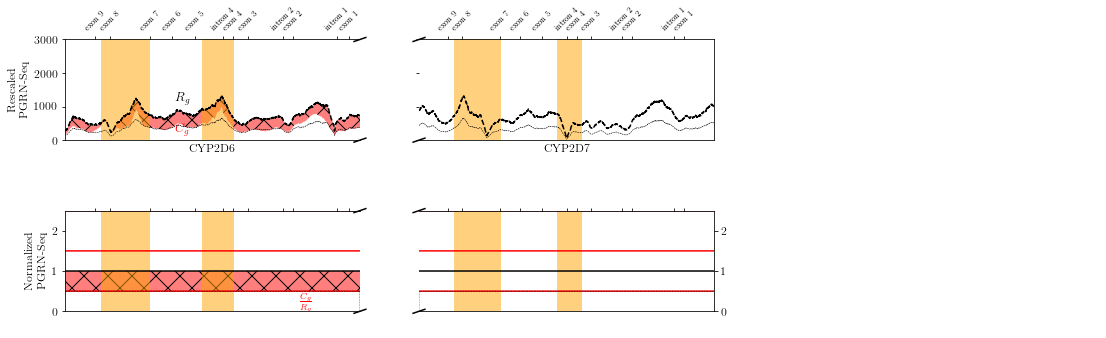

In [22]:
# Figure 2 / deletion
p = profiles['NA12155']
ax1, _, ax3, ax4, ax5, y, st = xplot('(ii) \\textit{CYP2D6}: *1/*5 (whole gene deletion)', None, deletion=(p, dict(color='red')), single=single)
ax1.fill_between(range(len(pgrnref)), p[:len(pgrnref)], pgrnref, facecolor='red', lw=0, alpha=0.5, hatch='x')
ax4.fill_between(range(10000), y[:10000], [1] * 10000, facecolor='red', lw=0, alpha=0.5, hatch='x')

ax1.annotate('$R_g$', xy=(175,235), xycoords='figure points', size='13')
ax1.annotate('$C_g$', xy=(175,204), xycoords='figure points', color='red', size='13')

ax4.annotate('$\\frac{C_g}{R_g}$', xy=(300,28), xycoords='figure points', color='red', size='13')

ax3.cla()
ax3.axis('off')
# plt.savefig('fig_sup_2b.pdf',  dpi=fig.dpi, bbox_inches='tight')

### _CYP2D6.68_ Fusion

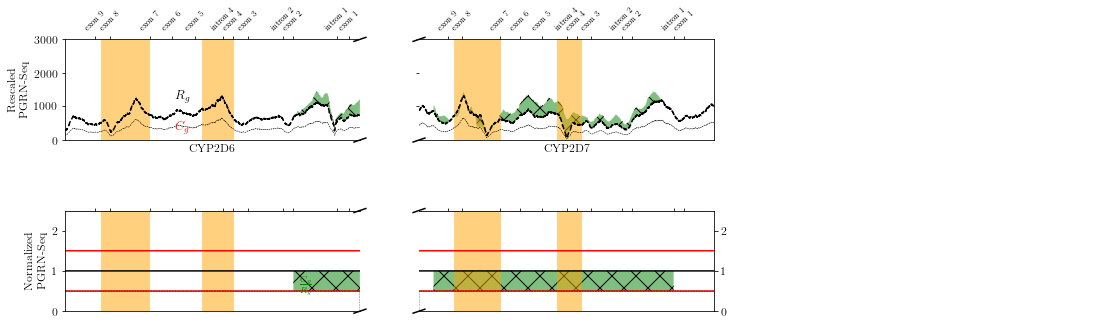

In [23]:
#%% Plot figure (2)/(iii)
p = profiles['NA12878']
ax1, ax2, ax3, ax4, ax5, y, st = xplot('(iv) \\textit{CYP2D6}: *10/*68+*4 (gene fusion in intron 1)', None, insertion=(p, dict(color='red')), single=single)
r = (6941, 8000)
ax1.fill_between(range(r[0], r[1]), p[r[0]:r[1]], pgrnref[r[0]:r[1]], facecolor='green', lw=0, alpha=0.5, hatch='x')
ax4.fill_between(range(r[0], r[1]), y[r[0]:r[1]], [1] * (r[1]-r[0]), facecolor='green', lw=0, alpha=0.5, hatch='x')
r = (17246, 21310)
ax2.fill_between(range(r[0], r[1]), p[r[0]:r[1]], pgrnref[r[0]:r[1]], facecolor='green', lw=0, alpha=0.5, hatch='x')
ax5.fill_between(range(r[0], r[1]), y[r[0]:r[1]], [1] * (r[1]-r[0]), facecolor='green', lw=0, alpha=0.5, hatch='x')

ax3.cla()
ax3.axis('off')

ax1.annotate('$R_g$', xy=(175,235), xycoords='figure points', size='13')
ax1.annotate('$C_g$', xy=(175,204), xycoords='figure points', color='red', size='13')

ax4.annotate('$\\frac{C_g}{R_g}$', xy=(300,43), xycoords='figure points', color='green', size='13')
# plt.savefig('fig_sup_2c.pdf',  dpi=fig.dpi, bbox_inches='tight')